# Approximation of the square function with deep ReLU NNs

In this notebook, we want to create the network from the paper "Error bounds for approximations with deep ReLU networks" by D. Yarotsky (Neural Netowrks, 2017, https://doi.org/10.1016/j.neunet.2017.07.002).

We start by considering the function
$$
F_1 : x\mapsto 
\begin{cases}
2x &x\in (0, 1/2]\\
2-2x &x \in (1/2, 1)\\
0 &\text{elsewhere.}
\end{cases}
$$
The first step is to define a NN $\Phi^\wedge$ with ReLU activation that emulates the function $F_1$. We start with the classical imports.


In [1]:
import deepNN as dnn
import torch
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

torch.set_default_device('cpu')

I'm using:  cuda


We then create the neural network, using the class in the `deepNN` module. Note that one has to rewrite $F_1$ as a ReLU NN; we have seen how to this in the lecture.

In [2]:
input_weight_mat = torch.tensor([[2.],[2.], [2.]])
input_bias_vec = torch.Tensor([0., -1., -2.])
output_weight_mat = torch.tensor([1., -2., 1.]).unsqueeze(0)


Phiwedge = dnn.DeepNet(torch.relu, 1, [3], 1)

Phiwedge.set_weight(0, input_weight_mat)
Phiwedge.set_bias(0, input_bias_vec) 

Phiwedge.set_output_weight(output_weight_mat)


We now plot the network output in $[0,1]$.

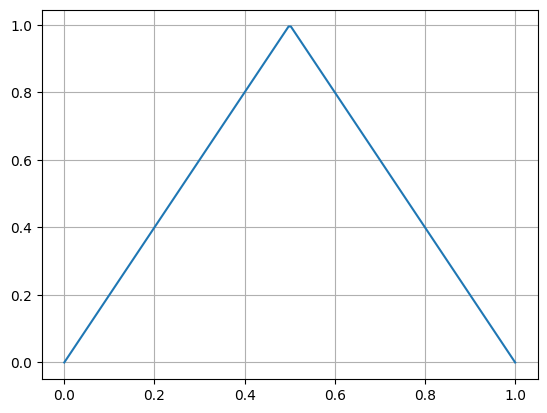

In [3]:
x = torch.linspace(0, 1, 200)
y = Phiwedge(x)

x_np = x.detach().numpy()
 
plt.plot(x_np, y.detach().numpy(), label='f')
plt.grid()
plt.show()

We now create a function that concatenates two networks (non-sparse concatenation).

In [4]:
def concatenate(nn1, nn2):
    assert nn1.dim_out == nn2.dim
    assert nn1.activation == nn2.activation
    new_L = nn1.L + nn2.L 
    new_widths = nn1.widths + nn2.widths
    out_net = dnn.DeepNet(nn1.activation, nn1.dim, new_widths, nn2.dim_out)

    for i in range(nn1.L):
        out_net.set_weight(i, nn1.hidden[i].weight)
        out_net.set_bias(i, nn1.hidden[i].bias)
    new_weight = nn2.hidden[nn2.L-1].weight@nn1.output.weight
    out_net.set_weight(nn1.L, new_weight)
    out_net.set_bias(nn1.L, nn2.hidden[nn2.L-1].bias)
    for i in range(1, nn2.L):
        out_net.set_weight(nn1.L+i, nn2.linear[i].weight)
        out_net.set_bias(nn1.L+i, nn2.linear[i].bias)
    out_net.set_output_weight(nn2.output.weight)

    return out_net

## controllare che la funzione qui sopra funzioni in ogni caso

We plot the output of $F_4 = F_1\circ F_1 \circ F_1 \circ F_1$

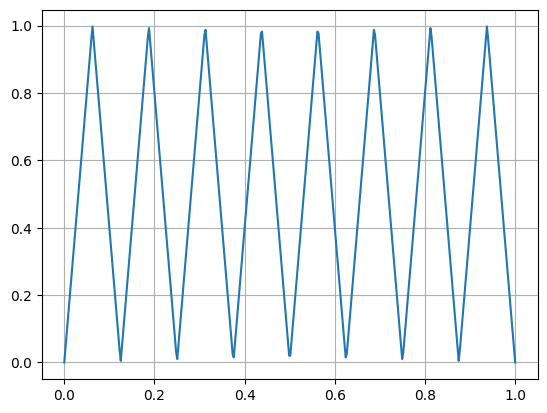

In [5]:
F4 = concatenate(concatenate(concatenate(Phiwedge, Phiwedge), Phiwedge), Phiwedge)

x = torch.linspace(0, 1, 400)
y = F4(x)

x_np = x.detach().numpy()
 
plt.plot(x_np, y.detach().numpy(), label='f')
plt.grid()
plt.show()

We now want to construct the network from Yarotsky's paper. Defining by $F_n$ the $n$-fold composition of $\Phi^\wedge$, we use the fact that
$$
x - \sum_{k=1}^N \frac{F_k(x)}{4^k} \to x^2, \qquad \text{as }N\to\infty,
$$ 
for all $x\in[0,1]$. The network therefore uses a non-standard architecture, as shown in this picture:

<center>
    <img src="./Yarotsky-arch.png" alt="Architecture">
</center>

We introduce a new class with this specific architecture, and copy into it the weights that we get from the concatenation (this is obviously not very efficient, but we're dealing with very small objects)

In [6]:
class YarotskyNet(dnn.DeepNet):
    def __init__(self, net, out_weights):
        """
        Initialize by copying a net given as input, and a vector of
        weights that are the weights of the skip connections
        """
        super(YarotskyNet, self).__init__(net.activation, net.dim, net.widths, net.dim_out)
        self.out_weights = out_weights
        for i in range(net.L):
            self.hidden[i] = net.hidden[i]
        self.output = net.output
        assert len(out_weights) == len(net.widths) + 1
 
    def forward(self, x):
        if x.dim() == 1:
            x = x[:, None]
        y = self.out_weights[0]*x
        for i in range(self.L):
            x = self.hidden[i](x)
            x = self.activation(x)
            y = y + self.out_weights[i+1]*self.output(x)
        return y
        

We now use the class and plot one specific approximation.

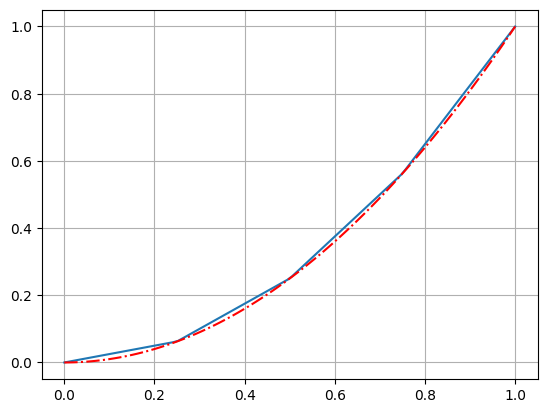

L2 error: 0.011353688768768489


In [9]:
depth = 3

out_weights = [-4**(-k) for k in range(depth)]
out_weights[0] = 1

basenet = Phiwedge
for j in range(depth-2):
    basenet = concatenate(basenet, Phiwedge)
    

squarenet = YarotskyNet(basenet, out_weights)


x = torch.linspace(0, 1, 100)
y = squarenet(x)

x_np = x.detach().numpy()


plt.plot(x_np, y.detach().numpy(), label='f')
plt.plot(x_np, x_np**2, 'r-.')
plt.grid()
plt.show()

print(f"L2 error: {np.linalg.norm(y.detach().numpy().flatten()-x_np**2)/10}")

We conclude by plotting the $L^2$ error as a function of the depth of the network. We should be able to see exponential convergence with respect to the network depth.

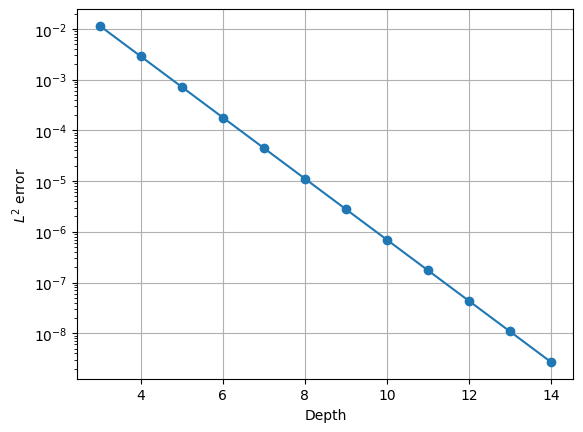

[0.011410880909246227,
 0.002852720227311557,
 0.0007131800568278893,
 0.0001782950142069723,
 4.4573753551743094e-05,
 1.1143438387935789e-05,
 2.7858595969839654e-06,
 6.964648992460036e-07,
 1.741162248115305e-07,
 4.352905620286586e-08,
 1.088226405080778e-08,
 2.7205660126970866e-09]

In [10]:
def compute_err(depth):
    out_weights = [-4**(-k) for k in range(depth)]
    out_weights[0] = 1

    basenet = Phiwedge
    for j in range(depth-2):
        basenet = concatenate(basenet, Phiwedge)
        

    squarenet = YarotskyNet(basenet, out_weights)

    Npts = 10**6
    x = torch.linspace(0, 1, Npts)
    y = squarenet(x)
    x_np = x.detach().numpy()

    return np.linalg.norm(y.detach().numpy().flatten()-x_np**2)/np.sqrt(Npts)

err = []
all_depths = range(3, 15)
for depth in all_depths:
    err.append(compute_err(depth))

plt.semilogy(all_depths, err, 'o-')
plt.grid()
plt.xlabel("Depth")
plt.ylabel("$L^2$ error")
plt.show()

err